# Image Selection

In [2]:
from pathlib import Path

from src.pipeline import Pipeline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
FILES = !ls inputs/*
FILES

['inputs/Atlas_de_Jacoubet_-_04._Partie_de_la_commune_de_Clichy_et_de_ses_environs_-_BHVP.jpg',
 'inputs/Atlas_de_Jacoubet_-_05._Partie_de_la_commune_de_Montmartre_et_de_ses_environs_-_BHVP.jpg',
 'inputs/Atlas_de_Jacoubet_-_06._Partie_de_la_commune_de_La_Chapelle_et_de_ses_environs_-_BHVP.jpg',
 'inputs/Atlas_de_Jacoubet_-_07._Barrire_de_la_Villette_et_ses_environs_-_BHVP.jpg',
 'inputs/Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses_environs_-_BHVP.jpg']

In [5]:
CST_INPUT_FILE = FILES[-1]
CST_OUPUT_DIRECTORY = Path(f"./labellized/{'_'.join(CST_INPUT_FILE.split('/')[-1].split('_-_')[:-1])}")
CST_OUPUT_DIRECTORY

PosixPath('labellized/Atlas_de_Jacoubet_11._Hospice_Beaujon_et_ses_environs')

# Run Pipeline

In [6]:
Pipeline(CST_INPUT_FILE, str(CST_OUPUT_DIRECTORY)).run()

# Get pipeline results

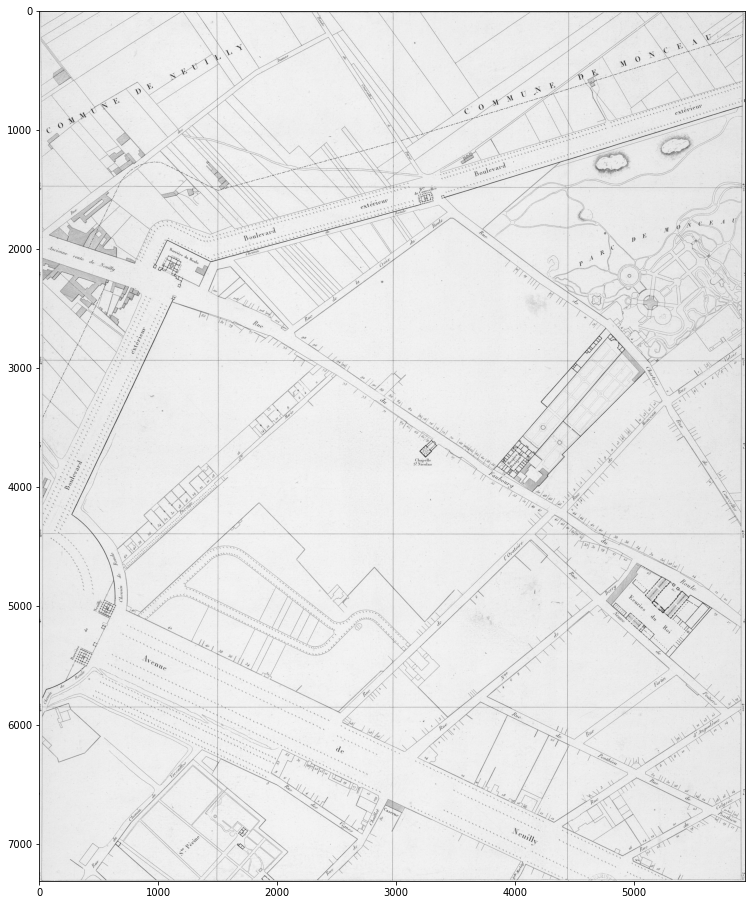

In [7]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from IPython import display

%matplotlib inline

image_dewarped = rgb2gray(imread(CST_OUPUT_DIRECTORY / "01_dewarped.png"))

plt.figure(figsize=(16,16))
imgplot = plt.imshow(image_dewarped,  cmap=plt.cm.gray)

In [8]:
generated_annotations = sorted(CST_OUPUT_DIRECTORY.glob("04_segments/*.json"), key=lambda path: path.name.split('.')[0])
generated_segments = [path.parent / f"{path.name.split('.')[0]}.png" for path in generated_annotations]
assert(all(map(lambda ann: ann.exists(), generated_segments))) # check that all segments exists
len(generated_segments)

669

# Labelize Images

In [9]:
from matplotlib.patches import Rectangle
import numpy as np
from IPython import display
import ipywidgets as widgets

class SegmentDisplayer:
    def __init__(self, image_original, image_segment, bot, top, figsize=(10, 10)):
        self.image_original = image_original
        self.image_segment = image_segment
        self.bot = bot
        self.top = top
        self.figsize = figsize 
        
    def _get_image_origin_window(self, bot, top):
        return self.image_original[bot[0]:top[0],bot[1]:top[1]]
        
    def show_comparison(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=self.figsize, sharex=True, sharey=True)
        ax = axes.ravel()
        
        ax[0].imshow(self._get_image_origin_window(self.bot, self.top), cmap=plt.cm.gray)
        ax[0].set_title("Original Segment")

        ax[1].imshow(self.image_segment)
        ax[1].set_title("Processed Segment")

        for a in ax:
            a.axis("off")

        fig.tight_layout()
        plt.show()

    
    def show_context(self, window_size=10):
        bot = np.maximum(np.subtract(self.bot, window_size), [0, 0])
        top = np.minimum(np.add(self.top, window_size), self.image_original.shape[:2])
        diff = np.subtract(self.top, self.bot)

        fig, ax = plt.subplots(1, figsize=self.figsize)
        ax.set_title("Segment Context")
        ax.axis("off")

        plt.imshow(self._get_image_origin_window(bot, top))
        
        rect = Rectangle((self.bot-bot)[::-1], diff[1], diff[0], edgecolor='r', linewidth=1, animated=True, facecolor='none')
        ax.add_patch(rect)

        plt.show()

In [26]:
image_labels = []

(self.bot-bot)[::-1]= [30 30]
diff= [15 22]


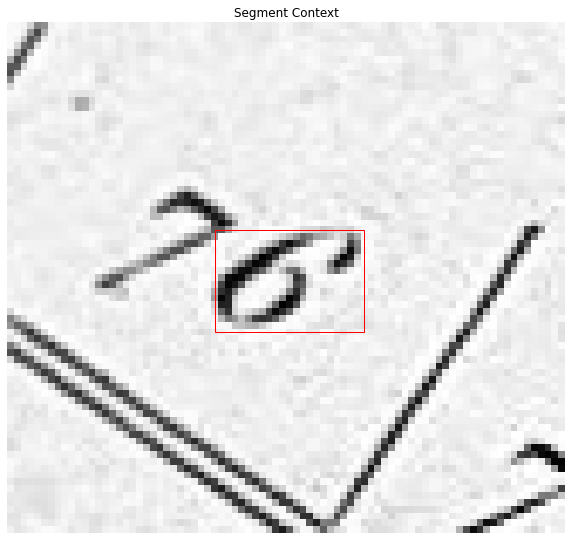

In [ ]:
def labelize_image_segments(image_origin, available_labels={}, labels=[]):
    import json
    from skimage.io import imread

    for i in range(len(labels), len(generated_annotations)):
        # Load annotation
        with open(generated_annotations[i], "r") as p_annotation:
            annotation = json.loads(p_annotation.read())

        (min_row, min_col, max_row, max_col) = annotation["bbox"]

        # Load images
        img_seg_origin = image_origin[min_row:max_row,min_col:max_col]
        img_seg_processed = imread(generated_segments[i])

        # Show images
        seg_display = SegmentDisplayer(image_origin, img_seg_processed, bot=[min_row, min_col], top=[max_row, max_col])
        seg_display.show_context()

        # Parse user input
        while True:
            user_input = input()
            if len(user_input) == 0 or user_input in available_labels:
                user_input = None if len(user_input) == 0 else user_input
                labels.append(user_input)
                break
            elif user_input == "q":
                return labels
            elif user_input == "cmp":
                display.clear_output(wait=True)
                seg_display.show_comparison()
            elif user_input[:3] == "ctx":
                user_input_params = user_input.split(' ')
                try:
                    window_size = int(user_input_params[1])
                except:
                    window_size = 10
                display.clear_output(wait=True)
                seg_display.show_context(window_size=window_size)
            else:
                print(f"the label `{user_input}` doesn't exist, please select one in: `{available_labels}`. Or leave it"
                      f"empty if the segment cannot be labelled (i.e. noise class)")

        # Reset Loop
        display.clear_output(wait=True)
 
    return labels

image_labels = labelize_image_segments(image_dewarped, set(str(i) for i in range(11)), labels=image_labels)

# Save the dataset

In [28]:
class FileNameGenerator:
    def __init__(self, labels, working_dir = Path("./data/"), fmt_padding=4):
        self._filenames = {}
        self._labels = {k: 0 for k in labels}
        self._working_dir = working_dir
        self._fmt_padding = fmt_padding

        Path(working_dir).mkdir(parents=True, exist_ok=True)

    def next(self, label) -> Path:
        if label not in self._labels:
            raise Exception(f"unknown label '{label}' has been given")

        idx = self._labels[label]
        self._labels[label] += 1

        name = f"{idx:0{self._fmt_padding}}.png"

        directory = self._working_dir / label
        if not directory.exists():
            directory.mkdir()

        return directory / name

In [29]:
import shutil

filename_gen = FileNameGenerator(working_dir=CST_OUPUT_DIRECTORY / "dataset", labels=set(str(i) for i in range(11)).union({"noise"}))

for i in range(len(image_labels)):
    lbl = image_labels[i]
    if lbl is None: # noise
        lbl = "noise"
    
    path = filename_gen.next(lbl)
    
    # FIXME: segment itself is really poor in information, we must save it with context.
    #        > strategy 1:  strategy maybe saving one image and save different information on different channels
    #           ex: - red: contains context (window around area of interest)
    #               - green: contains area of interest (extracted num)
    #               - blue: contains road? to retrieve rotation for example?
    #        > strategy 2: save a .json along the file containing all informations we might need (i don't like it)
    
    shutil.copy(generated_segments[i], path)
    